In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import google.colab
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/fraud_detection_dataset.csv'
data = pd.read_csv(file_path)

# Selección de características
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'type']
X = data[features]
y = data['isFraud']

# Preprocesamiento de datos
# Codificación one-hot para la columna 'type'
X = pd.get_dummies(X, columns=['type'])

# Imputación de valores faltantes con KNNImputer
imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(X)

# Escalado de características numéricas
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Balanceo de clases utilizando SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Reducir el sampling_strategy si es posible
X_res, y_res = smote.fit_resample(X, y)

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Entrenamiento de un modelo base
clf_base = DecisionTreeClassifier(random_state=42)
clf_base.fit(X_train, y_train)
base_score = roc_auc_score(y_test, clf_base.predict(X_test))
print(f"Puntaje base (sin optimización de hiperparámetros): {base_score:.4f}")

# Optimización de hiperparámetros mediante GridSearchCV (si es necesario)
if base_score < 0.8:  # Puedes ajustar este umbral según tus necesidades
    param_grid = {
        'max_depth': [5, 10],  # Reducir el rango de valores
        'min_samples_split': [2, 5],  # Reducir el rango de valores
        'min_samples_leaf': [1, 2]  # Reducir el rango de valores
    }

    clf = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='roc_auc', n_jobs=2)  # Reducir cv y n_jobs
    grid_search.fit(X_train, y_train)

    # Construcción del modelo de árbol de decisión con los mejores hiperparámetros
    clf_best = grid_search.best_estimator_

    # Predicciones
    y_pred = clf_best.predict(X_test)

    # Evaluación del modelo
    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Visualización de las reglas del árbol de decisión
    from sklearn.tree import export_text
    tree_rules = export_text(clf_best, feature_names=list(X.columns))
    print(tree_rules)
else:
    print("El puntaje base es aceptable. No se realizará la optimización de hiperparámetros.")

Mounted at /content/drive
Puntaje base (sin optimización de hiperparámetros): 0.9981
El puntaje base es aceptable. No se realizará la optimización de hiperparámetros.


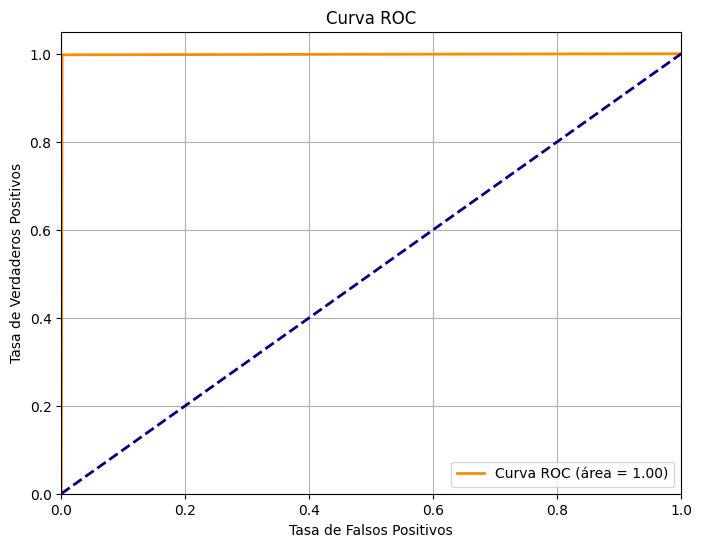

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

# Cálculo de las probabilidades y etiquetas predichas
y_pred_proba = clf_base.predict_proba(X_test)[:, 1]
y_pred = clf_base.predict(X_test)

# Gráfico de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)


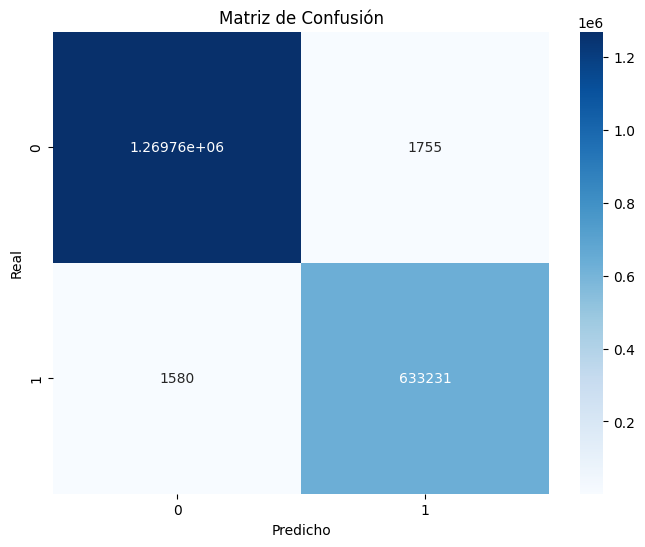

In [ ]:
# Gráfico de la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)


##Esta imagen muestra la curva ROC (Receiver Operating Characteristic) de un modelo de clasificación binaria. La curva ROC es una representación gráfica que ilustra el rendimiento de un modelo de clasificación al variar el umbral de clasificación.
##En el eje x se encuentra la tasa de falsos positivos, y en el eje y, la tasa de verdaderos positivos. Una curva ROC ideal sería una línea que sube verticalmente desde el origen hasta el punto (0,1) y luego avanza horizontalmente hasta el punto (1,1), indicando una clasificación perfecta.
##En este caso, la curva ROC representada por la línea azul punteada se aproxima bastante a la situación ideal, lo que sugiere un modelo de clasificación con un rendimiento muy bueno. El área bajo la curva ROC (AUC) es de 1.0, que es el valor máximo posible, lo que indica que el modelo es capaz de distinguir perfectamente entre las dos clases.
## En resumen, estos resultados muestran que el modelo de clasificación analizado tiene un excelente desempeño, con una capacidad casi perfecta para discriminar entre las clases positivas y negativas de los datos.

##Esta imagen representa una matriz de confusión para un problema de clasificación binaria. La matriz de confusión es una herramienta que permite visualizar el rendimiento de un modelo de clasificación comparando las predicciones realizadas por el modelo con las etiquetas reales de los datos.
##La matriz tiene dos filas y dos columnas, donde cada fila representa la clase real (0 o 1) y cada columna representa la clase predicha por el modelo (0 o 1).
##Los valores dentro de la matriz son:

##Verdaderos Negativos (arriba a la izquierda): 1.26976e+06 (1,269,760,000). Estos son los casos en los que el modelo predijo correctamente la clase 0.
##Falsos Positivos (arriba a la derecha): 1755. Estos son los casos en los que el modelo predijo erróneamente la clase 1, cuando la clase real era 0.
##Falsos Negativos (abajo a la izquierda): 1580. Estos son los casos en los que el modelo predijo erróneamente la clase 0, cuando la clase real era 1.
##Verdaderos Positivos (abajo a la derecha): 633231. Estos son los casos en los que el modelo predijo correctamente la clase 1.

##Analizando los valores, se observa que el modelo tiene un buen rendimiento en la predicción de la clase 0 (verdaderos negativos), pero presenta algunos errores en la predicción de la clase 1 (falsos negativos y falsos positivos).
## Es importante tener en cuenta que la interpretación de estos resultados depende del contexto específico del problema y de las implicaciones de los diferentes tipos de errores. Por lo general, se busca minimizar los falsos negativos y falsos positivos para mejorar el rendimiento del modelo.